<a href="https://colab.research.google.com/github/hyezzz/Lecture_assignment./blob/main/segnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
images = []
lesions = []
from skimage.io import imread
import os
root = '/content/drive/MyDrive/서울시립대/수업/도시빅데이터응용세미나/semantic-segmentation-tutorial-pytorch/minicity'
for f in sorted(os.listdir(os.path.join(root+'/gtFine', 'train'))):
    if os.path.join(root+'/gtFine/train/', f).endswith('instanceIds.png'):
        lesions.append(imread(os.path.join(root+'/gtFine/train/', f)))
        
for f in sorted(os.listdir(os.path.join(root+'/leftImg8bit', 'train'))):
    images.append(imread(os.path.join(root+'/leftImg8bit/train/', f)))

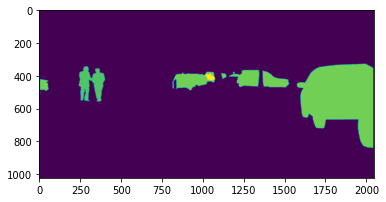

In [4]:
import matplotlib.pyplot as plt

# plt.imshow(images[4])
plt.imshow(lesions[4])


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [6]:
len(lesions)

200

In [7]:
X.shape, Y.shape

((200, 256, 256, 3), (200, 256, 256))

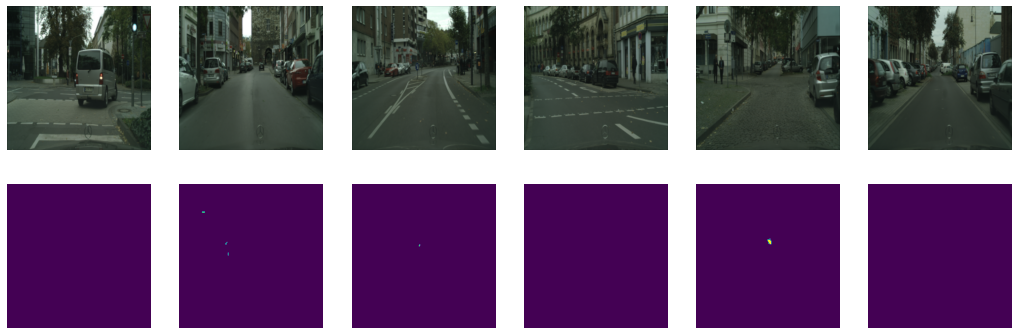

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [9]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [10]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [11]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [12]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda



-----------------------------------------------------------------------------------------

# SegNet

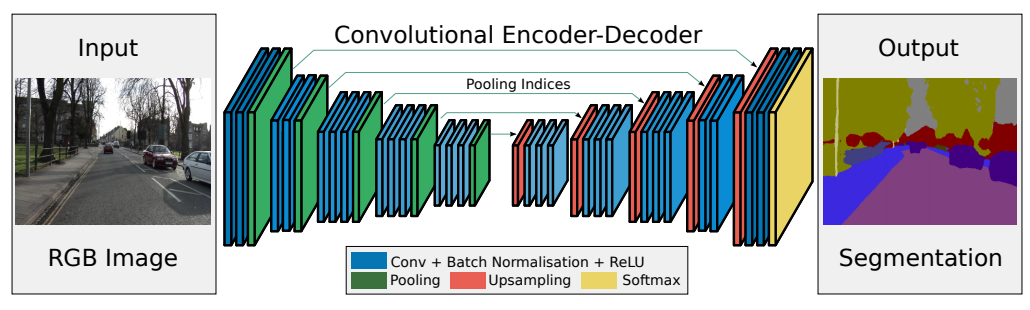


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [14]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1, ind1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0))  # no activation
        return d3

In [15]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded 

In [16]:
def bce_loss(y_real, y_pred):
    return (torch.clamp(y_pred, 0) - y_real * y_pred + torch.log(1 + torch.exp(-abs(y_pred)))).mean()

In [17]:
def train(model, opt, loss_fn, metric, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    history = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_tr_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_tr_loss += loss / len(data_tr)

        metric_tr = score_model(model, metric, data_tr)

        avg_val_loss = 0
        model.eval()  # testing mode
        for X_batch, Y_batch in data_val:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            with torch.no_grad():
                Y_pred = model(X_batch)
                loss = loss_fn(Y_batch, Y_pred)
                avg_val_loss += loss / len(data_val)

        metric_val = score_model(model, metric, data_val)

        history.append((avg_tr_loss, metric_tr, avg_val_loss, metric_val))

        toc = time()
        print('loss: %f' % avg_tr_loss)

        # show intermediate results
        Y_hat = (model(X_val.to(device)) > 0.5).detach().cpu() # detach and put into cpu

        # Visualize tools
        # clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_tr_loss))
        plt.show()
    
    return history

In [18]:
def show_history(history):
    loss, acc, val_loss, val_acc = zip(*history)

    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

    plt.figure(figsize=(15, 9))
    plt.plot(acc, label="train_iou")
    plt.plot(val_acc, label="val_iou")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.show()

In [19]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = model(data.to(device)).cpu() > 0.5
    return np.array(Y_pred)

In [20]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = (model(X_batch.to(device)) > 0.5)
            scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

In [21]:
segnet_bce = SegNet().to(device)

* Epoch 1/30


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:693: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch._C._nn.max_pool2d_with_indices(input, kernel_size, stride, padding, dilation, ceil_mode)


loss: 0.675767


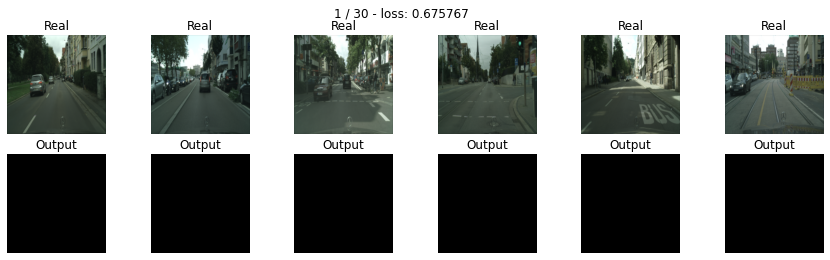

* Epoch 2/30
loss: 0.407976


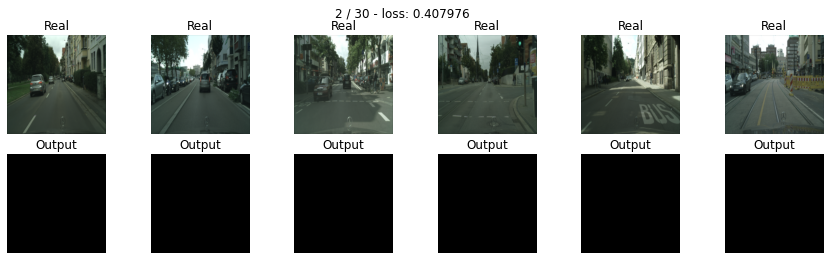

* Epoch 3/30
loss: 0.206831


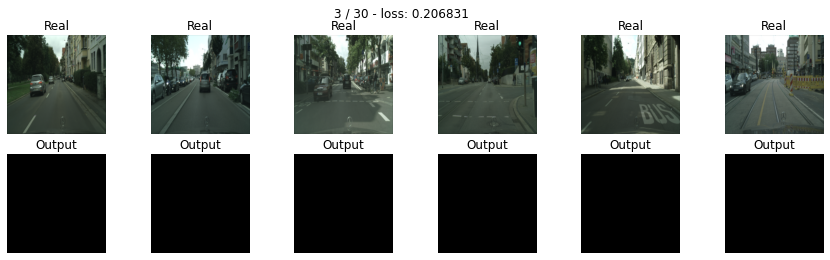

* Epoch 4/30
loss: 0.115080


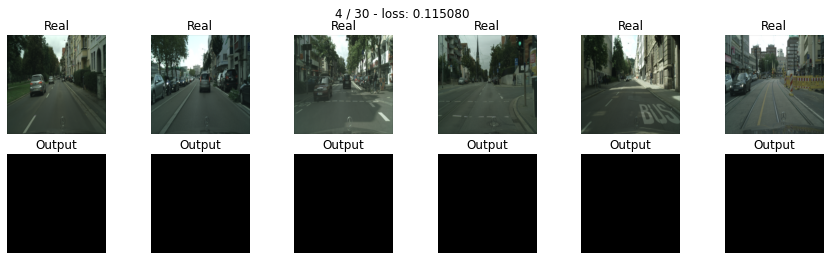

* Epoch 5/30
loss: 0.072329


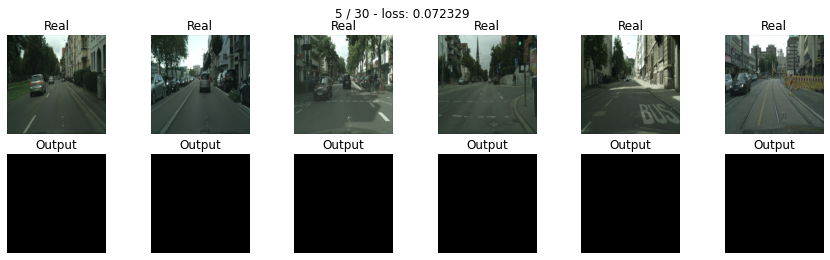

* Epoch 6/30
loss: 0.052276


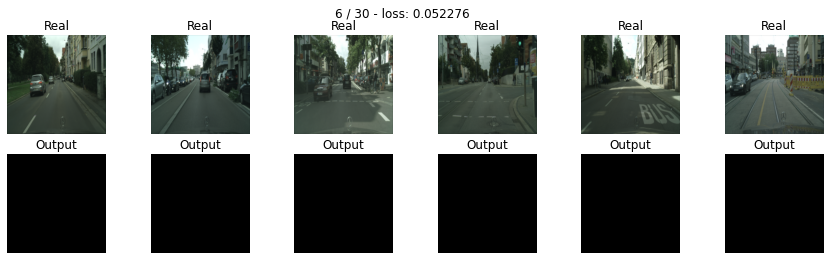

* Epoch 7/30
loss: 0.041462


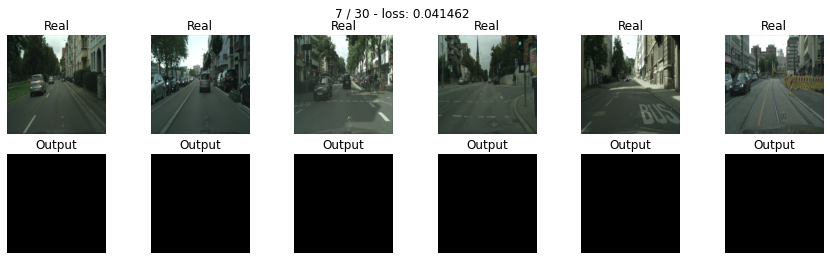

* Epoch 8/30
loss: 0.035390


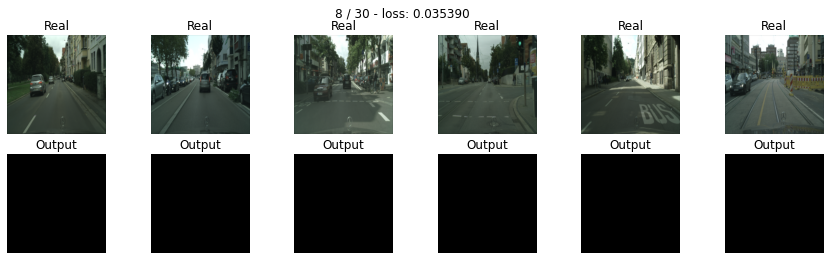

* Epoch 9/30
loss: 0.031494


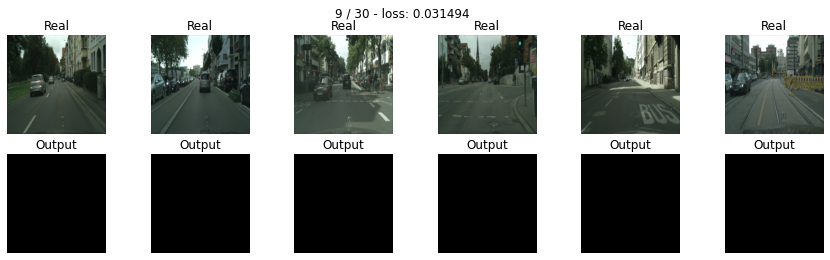

* Epoch 10/30
loss: 0.028766


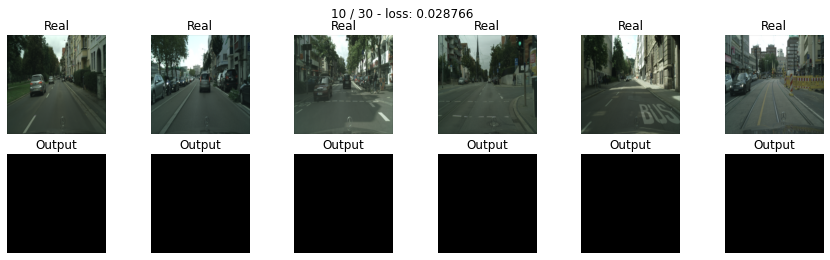

* Epoch 11/30
loss: 0.027127


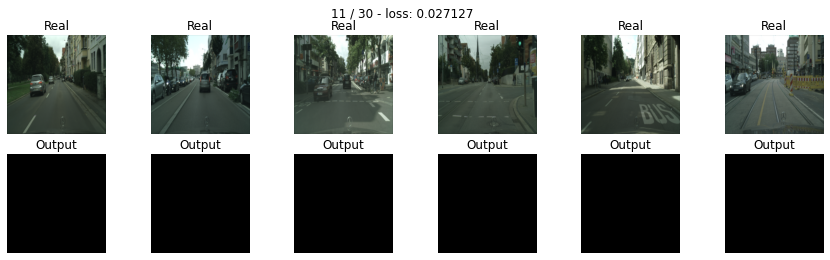

* Epoch 12/30
loss: 0.025426


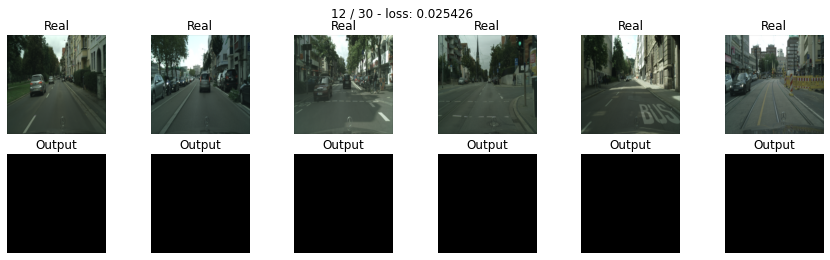

* Epoch 13/30
loss: 0.024337


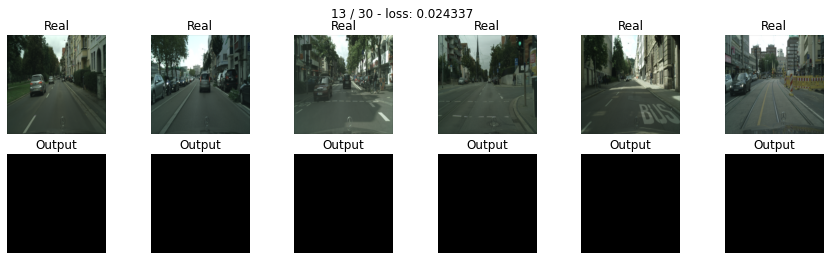

* Epoch 14/30
loss: 0.023440


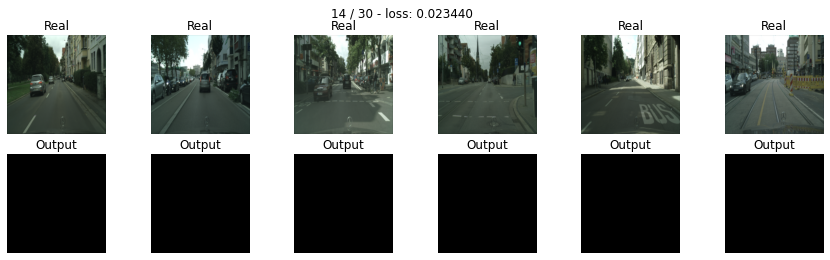

* Epoch 15/30
loss: 0.022317


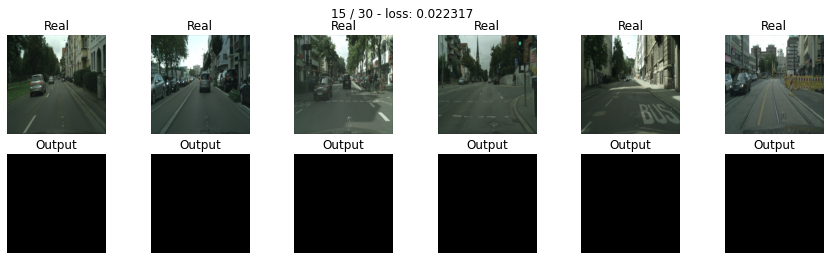

* Epoch 16/30
loss: 0.021430


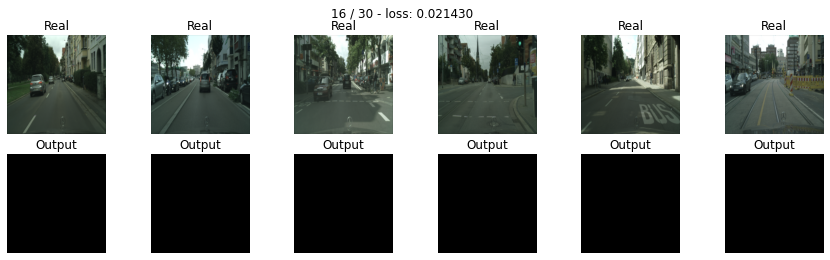

* Epoch 17/30
loss: 0.020009


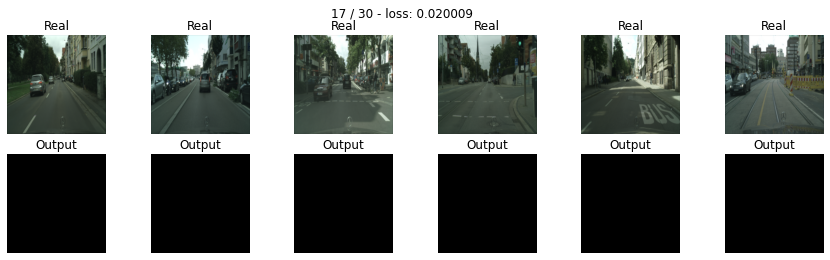

* Epoch 18/30
loss: 0.019219


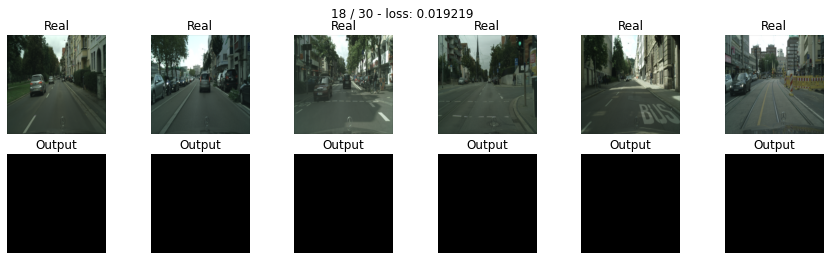

* Epoch 19/30
loss: 0.018718


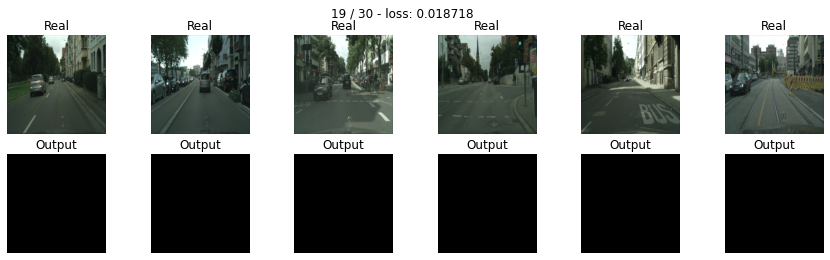

* Epoch 20/30
loss: 0.017534


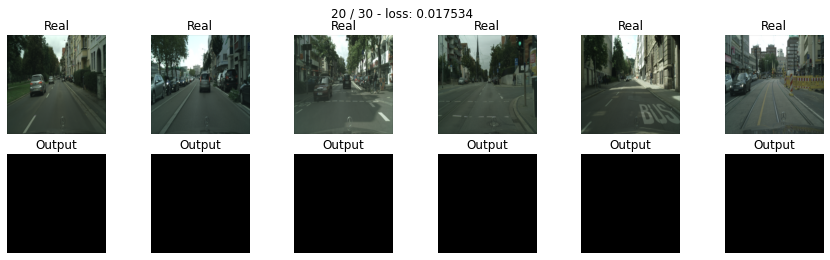

* Epoch 21/30
loss: 0.018781


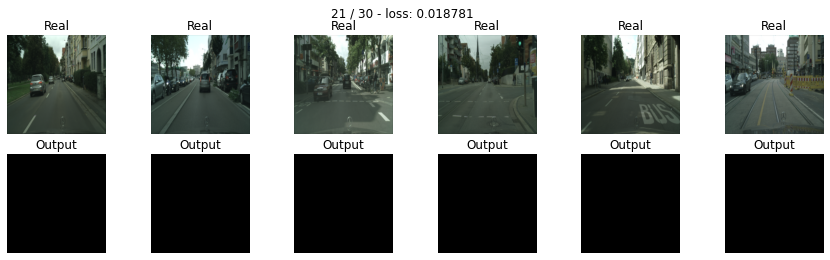

* Epoch 22/30
loss: 0.018203


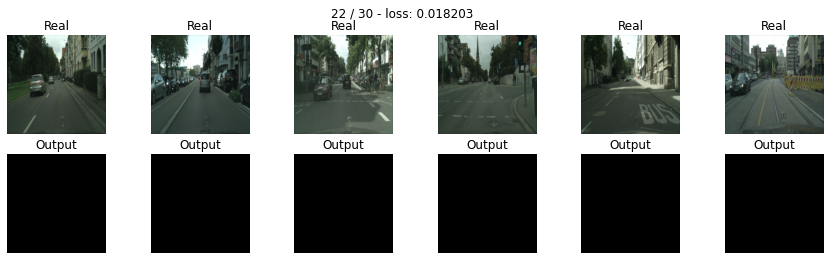

* Epoch 23/30
loss: 0.017429


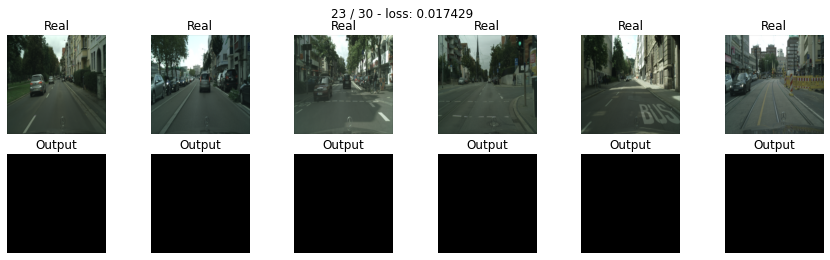

* Epoch 24/30
loss: 0.016631


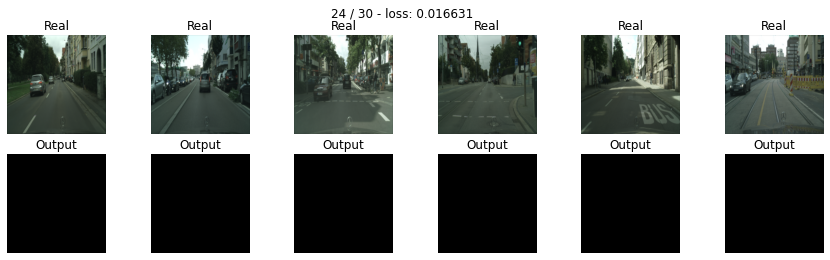

* Epoch 25/30
loss: 0.015811


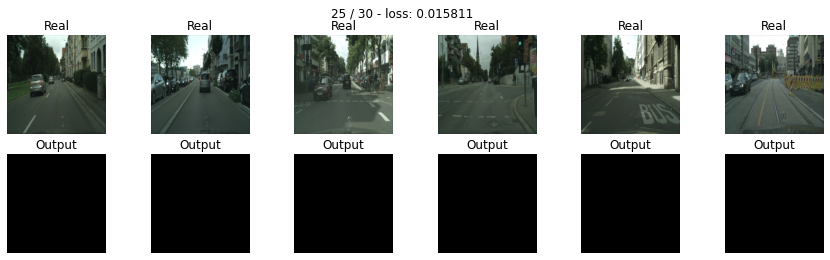

* Epoch 26/30
loss: 0.015530


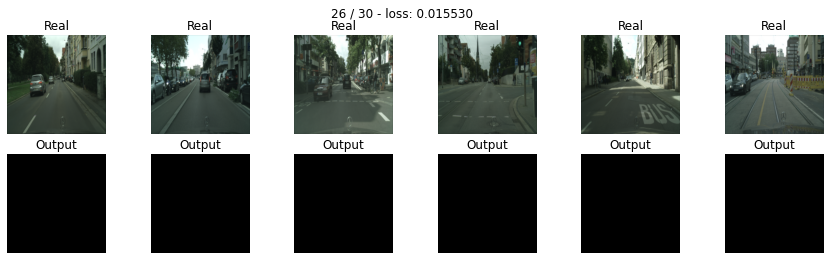

* Epoch 27/30
loss: 0.016104


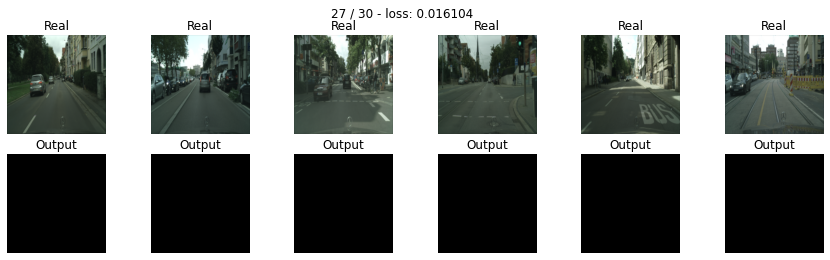

* Epoch 28/30
loss: 0.015146


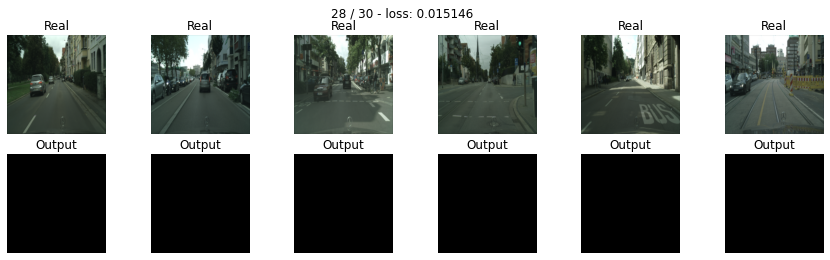

* Epoch 29/30
loss: 0.015759


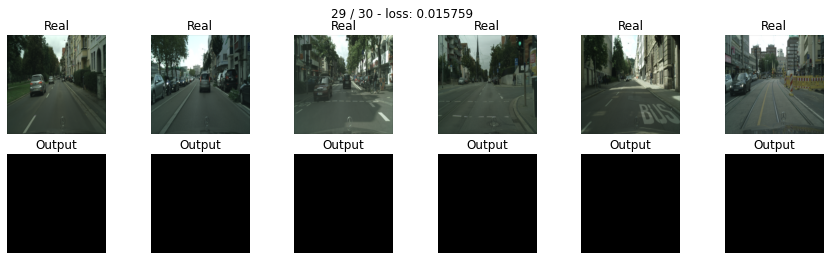

* Epoch 30/30
loss: 0.016366


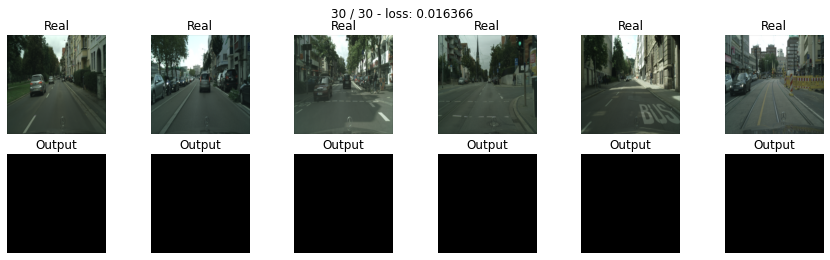

In [22]:
max_epochs = 30
opt = optim.Adam(segnet_bce.parameters(), lr=3e-4)
bce_history = train(segnet_bce, opt, bce_loss, iou_pytorch, max_epochs, data_tr, data_val)

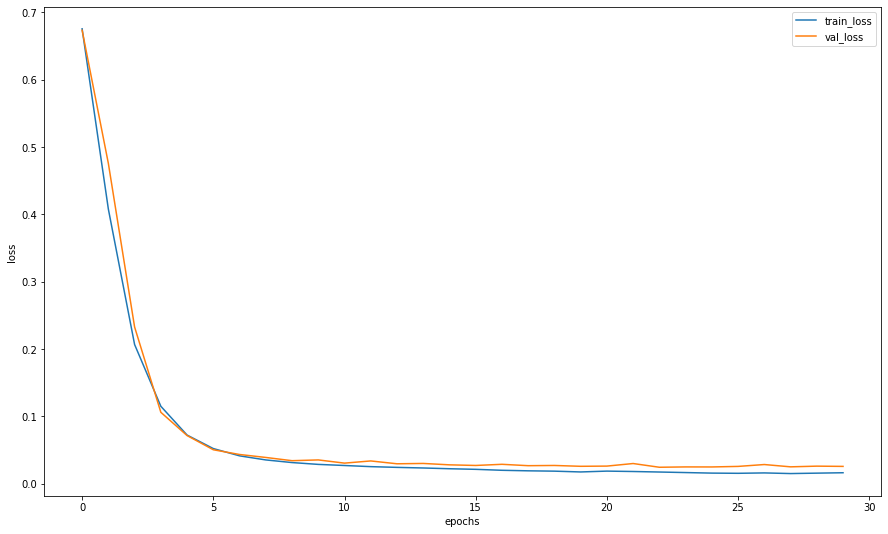

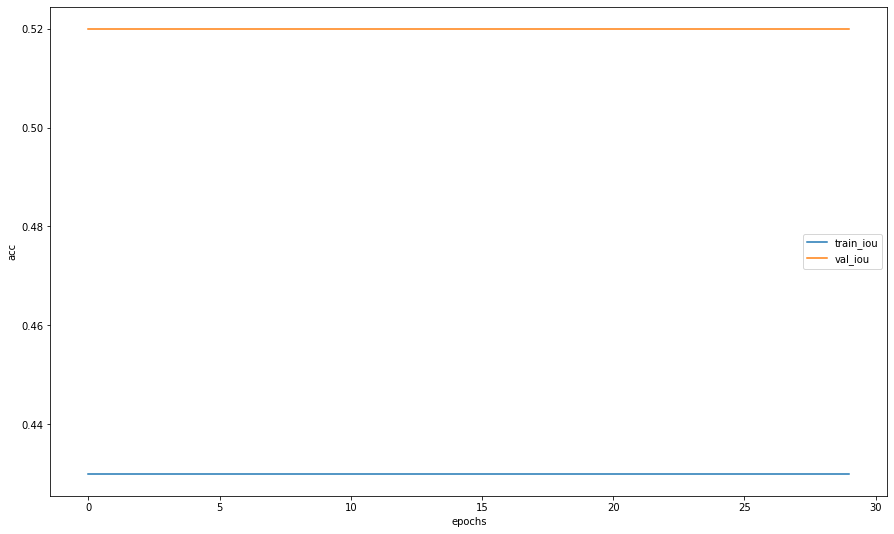

In [23]:
show_history(bce_history)

In [24]:
score_model(segnet_bce, iou_pytorch, data_ts)

0.4800000011920929